# Jun 28th, 2022 (full brain bold: KABA 128)

**Motivation**: K = 10, with and without prune, extremely overlapping, and prune does not change this much <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128, load_parcel=True, load_allen=True)

task = 'rest'
mice.setup_func_data(task)

num_k, p = None, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 2},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': True,
}
props_bo = {'mode': 'bold', **props_base}

## K = 10

In [3]:
props_bo['num_k'] = 10
bt = BootStrap(**props_bo)

### Deg distribution

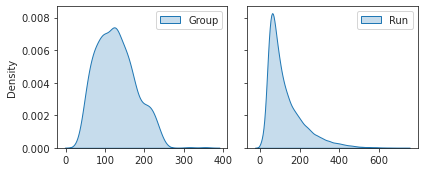

In [4]:
deg = avg(bt.run_deg, 1)

fig, axes = create_figure(1, 2, (6, 2.5), sharey='all')
sns.kdeplot(
    deg[np.isfinite(deg)],
    fill=True,
    label='Group',
    ax=axes[0],
)
sns.kdeplot(
    bt.run_deg[np.isfinite(bt.run_deg)],
    fill=True,
    label='Run',
    ax=axes[1],
)
for ax in axes.flat:
    ax.legend(loc='upper right')
plt.show()

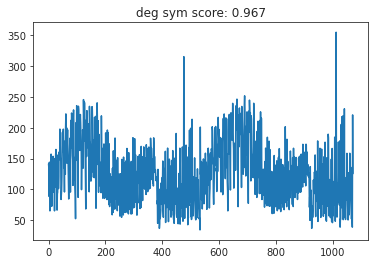

In [5]:
plt.plot(deg)
plt.title(f'deg sym score: {bt.pi_symmetry_score(deg.reshape(1, -1))[0][-1]}')
plt.show()

### Deg on cortex

In [6]:
np.nanmin(deg), np.nanmax(deg)

(33.977777777777774, 355.2166666666667)

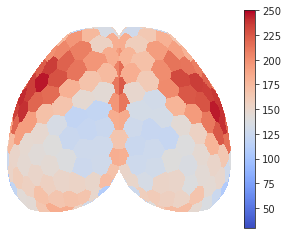

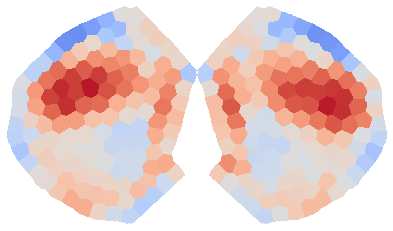

In [7]:
layer = 0
vmin = 30
vmax = 250

_ = bt.show(
    data=deg,
    vmin=vmin,
    vmax=vmax,
    mask_thresh=0.001,
    figsize=(5, 4),
    cmap='coolwarm',
    add_disjoint=False,
    contour=False,
    cbar=True,
    layer=layer,
)
_ = bt.show(
    data=deg,
    vmin=vmin,
    vmax=vmax,
    mask_thresh=0.001,
    figsize=(7, 4),
    cmap='coolwarm',
    proj='flat',
    add_disjoint=False,
    contour=False,
    layer=layer,
)

In [8]:
deg_sfc = bt.get_surface_pi(deg.reshape(1, -1)).squeeze()
np.nanmin(deg_sfc), np.nanmax(deg_sfc)

(0.0, 238.31388888888887)

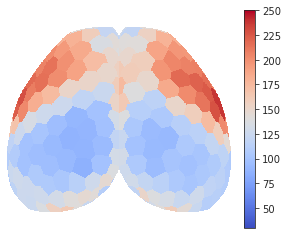

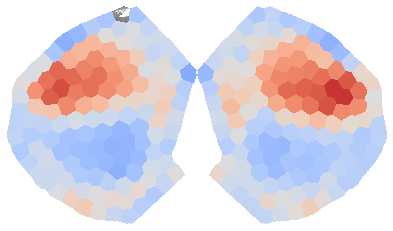

In [9]:
layer = 0
vmin = 30
vmax = 250

_ = bt.show(
    data=deg_sfc,
    vmin=vmin,
    vmax=vmax,
    mask_thresh=0.001,
    figsize=(5, 4),
    cmap='coolwarm',
    add_disjoint=False,
    contour=False,
    cbar=True,
    layer=layer,
)
_ = bt.show(
    data=deg_sfc,
    vmin=vmin,
    vmax=vmax,
    mask_thresh=0.001,
    figsize=(7, 4),
    cmap='coolwarm',
    proj='flat',
    add_disjoint=False,
    contour=False,
    layer=layer,
)

In [10]:
deg_vol = np_nans(mice.parcel['cortex'].shape)
for nn, lbl in bt.n2l.items():
    i = mice.parcel.encode(lbl)
    hcl = [int(e) for e in lbl.split('-')]
    if len(hcl) == 3:
        deg_vol[mice.parcel['cortex'] == i] = deg[nn]
    else:
        obj_name = f"subcortex-{'l' if hcl[0] == 1 else 'r'}"
        deg_vol[mice.parcel[obj_name] == i] = deg[nn]
deg_vol.shape

(132, 80, 114)

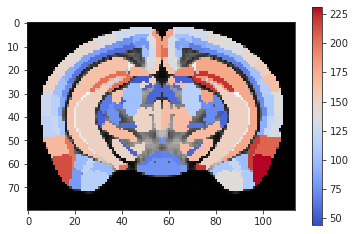

In [11]:
slice_i = 80
plt.imshow(mice.al.template[slice_i], cmap='Greys_r')
plt.imshow(deg_vol[slice_i], cmap='coolwarm')
plt.colorbar()
plt.show()

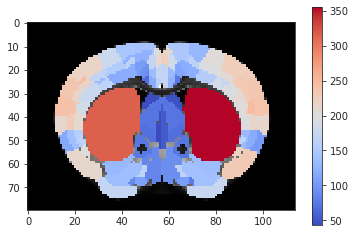

In [12]:
slice_i = 50
plt.imshow(mice.al.template[slice_i], cmap='Greys_r')
plt.imshow(deg_vol[slice_i], cmap='coolwarm')
plt.colorbar()
plt.show()

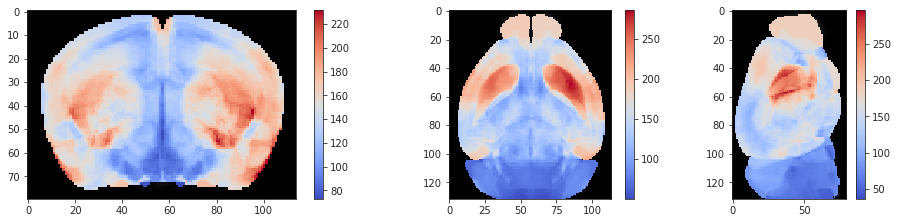

In [13]:
fig, axes = create_figure(1, 3, (13, 3.2), width_ratios=[1.9, 1.4, 1])

for i, ax in enumerate(axes):
    ax.imshow(mice.al.template.mean(i), cmap='Greys_r')
    im = ax.imshow(bn.nanmean(deg_vol, i), cmap='coolwarm')
    plt.colorbar(im, ax=ax)
plt.show()

### $\pi$ on cortex

In [14]:
bt.avg()
bt.pi.shape

(10, 1072)

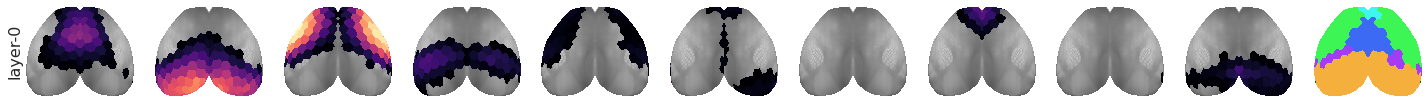

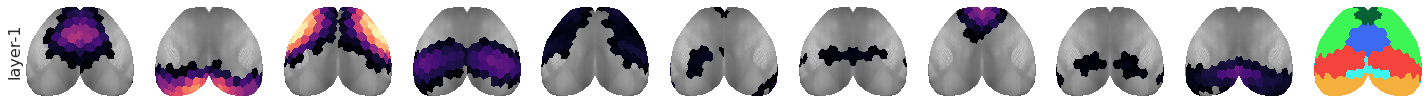

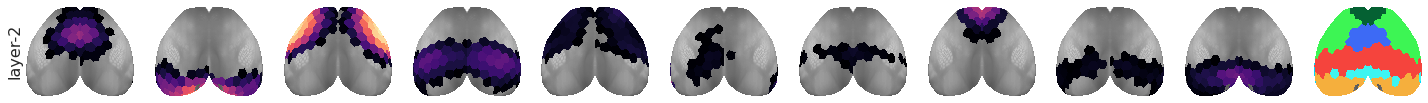

In [15]:
for i in range(3):
    _ = bt.show(
        data={f'layer-{i}': bt.pi},
        layer=i,
        vmin=0.1,
        vmax=np.nanmax(bt.pi),
        figsize=(25, 5),
        contour=False,
        ylabel_fontsize=16,
    )

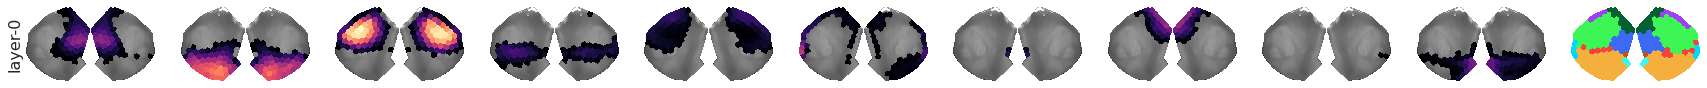

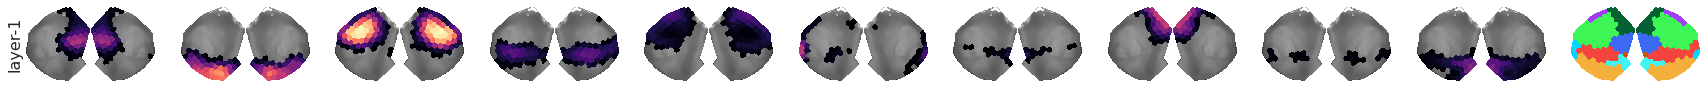

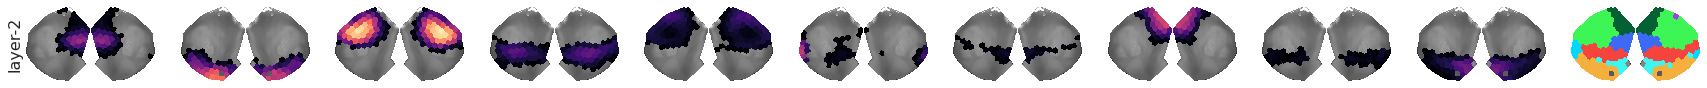

In [16]:
for i in range(3):
    _ = bt.show(
        data={f'layer-{i}': bt.pi},
        layer=i,
        vmin=0.1,
        vmax=np.nanmax(bt.pi),
        figsize=(30, 4.5),
        proj='flat',
        contour=False,
        ylabel_fontsize=16,
    )

#### Raw vs Prune

In [17]:
bt.pi_symmetry_score(avg(bt.run_pi))

(
    {
        1: 0.988,
        2: 0.983,
        3: 0.985,
        4: 0.858,
        5: 0.96,
        6: 0.868,
        7: 0.993,
        8: 0.994,
        9: 0.988,
        10: 0.969,
        -1: 0.959
    },
    {
        1: 0.996,
        2: 0.983,
        3: 0.972,
        4: 0.95,
        5: 0.987,
        6: 0.965,
        7: 0.996,
        8: 0.994,
        9: 0.993,
        10: 0.985,
        -1: 0.982
    }
)

In [18]:
bt.pi_symmetry_score(avg(bt.pi_prune))

(
    {
        1: 0.988,
        2: 0.984,
        3: 0.985,
        4: 0.854,
        5: 0.964,
        6: 0.871,
        7: 0.992,
        8: 0.993,
        9: 0.987,
        10: 0.967,
        -1: 0.959
    },
    {
        1: 0.996,
        2: 0.979,
        3: 0.968,
        4: 0.944,
        5: 0.987,
        6: 0.963,
        7: 0.994,
        8: 0.994,
        9: 0.993,
        10: 0.979,
        -1: 0.98
    }
)

In [19]:
x = bt.get_surface_pi(avg(bt.run_pi))
x_pr = bt.get_surface_pi(avg(bt.pi_prune))
x.shape, x_pr.shape

((10, 1072), (10, 1072))

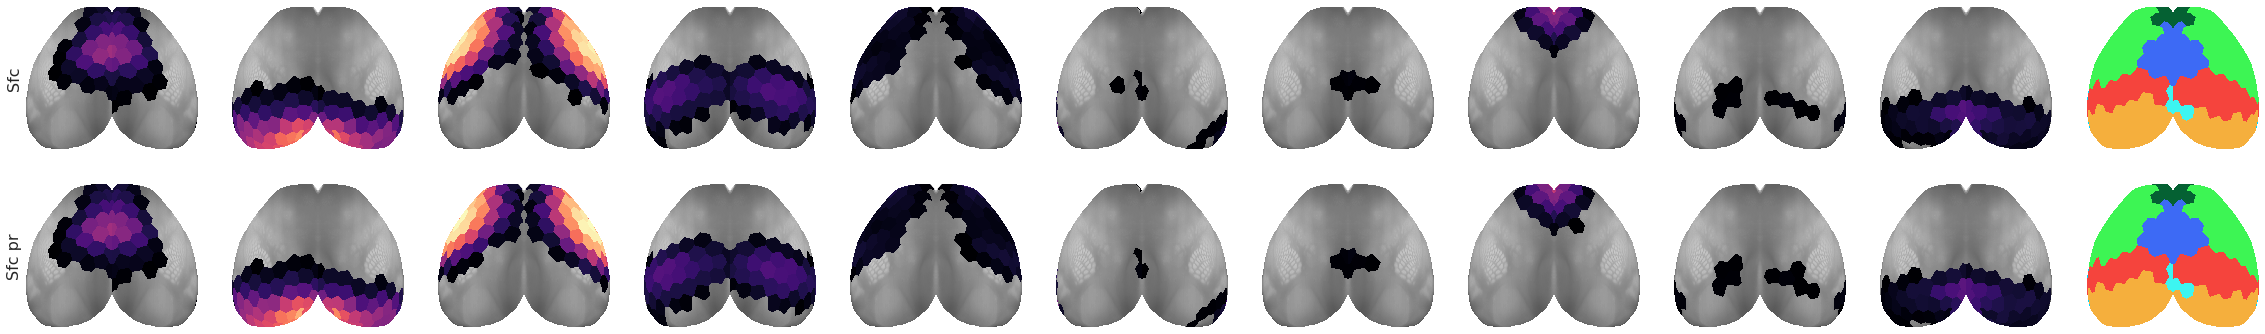

In [20]:
_ = bt.show(
    data={'Sfc': x, 'Sfc pr': x_pr},
    layer=0,
    vmin=0.1,
    vmax=max(np.nanmax(x), np.nanmax(x_pr)),
    contour=False,
    figsize=(40, 6),
    ylabel_fontsize=16,
)

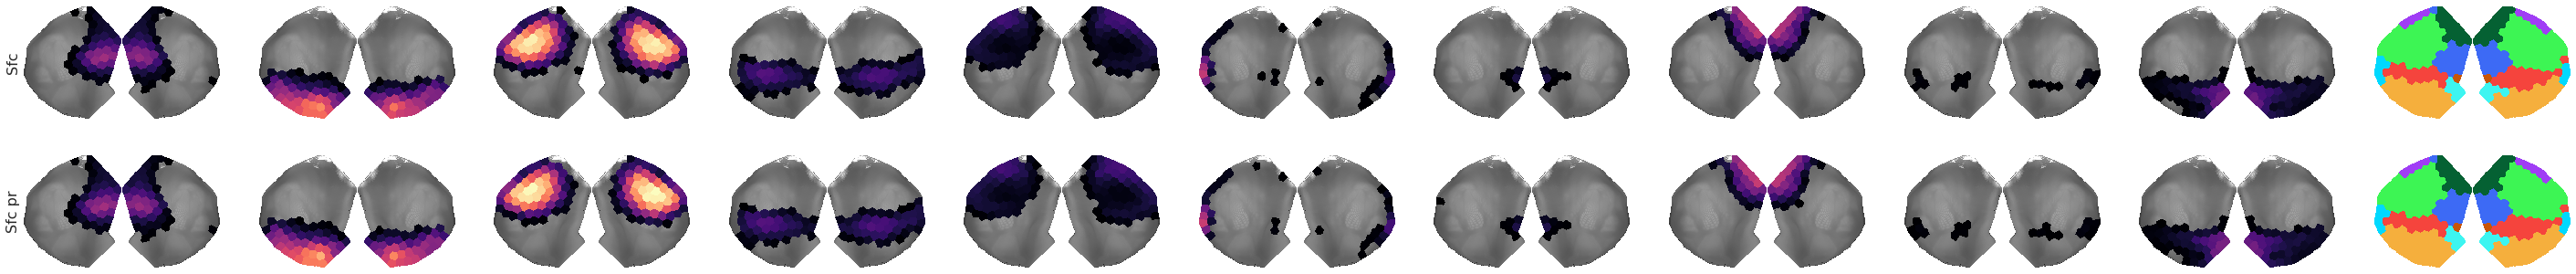

In [21]:
_ = bt.show(
    data={'Sfc': x, 'Sfc pr': x_pr},
    layer=0,
    vmin=0.1,
    vmax=max(np.nanmax(x), np.nanmax(x_pr)),
    contour=False,
    proj='flat',
    figsize=(50, 5.5),
    ylabel_fontsize=16,
)

In [22]:
pi_vol = np_nans((bt.num_k,) + mice.al.dims)
for nn, lbl in bt.n2l.items():
    i = mice.parcel.encode(lbl)
    hcl = [int(e) for e in lbl.split('-')]
    if len(hcl) == 3:
        pi_vol[:, mice.parcel['cortex'] == i] = bt.pi[:, [nn]]
    else:
        obj_name = f"subcortex-{'l' if hcl[0] == 1 else 'r'}"
        pi_vol[:, mice.parcel[obj_name] == i] = bt.pi[:, [nn]]
pi_vol.shape

(10, 132, 80, 114)

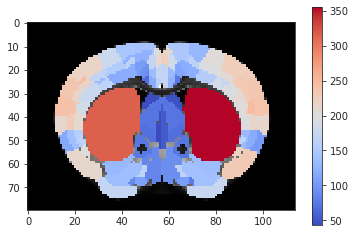

In [23]:
slice_i = 50
plt.imshow(mice.al.template[slice_i], cmap='Greys_r')
plt.imshow(deg_vol[slice_i], cmap='coolwarm')
plt.colorbar()
plt.show()

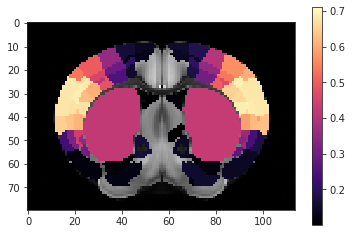

In [24]:
oc = 2
slice_i = 50
plt.imshow(mice.al.template[slice_i], cmap='Greys_r')
plt.imshow(mwh(pi_vol[oc, slice_i] < 0.1, pi_vol[oc, slice_i]), cmap='magma')
plt.colorbar()
plt.show()

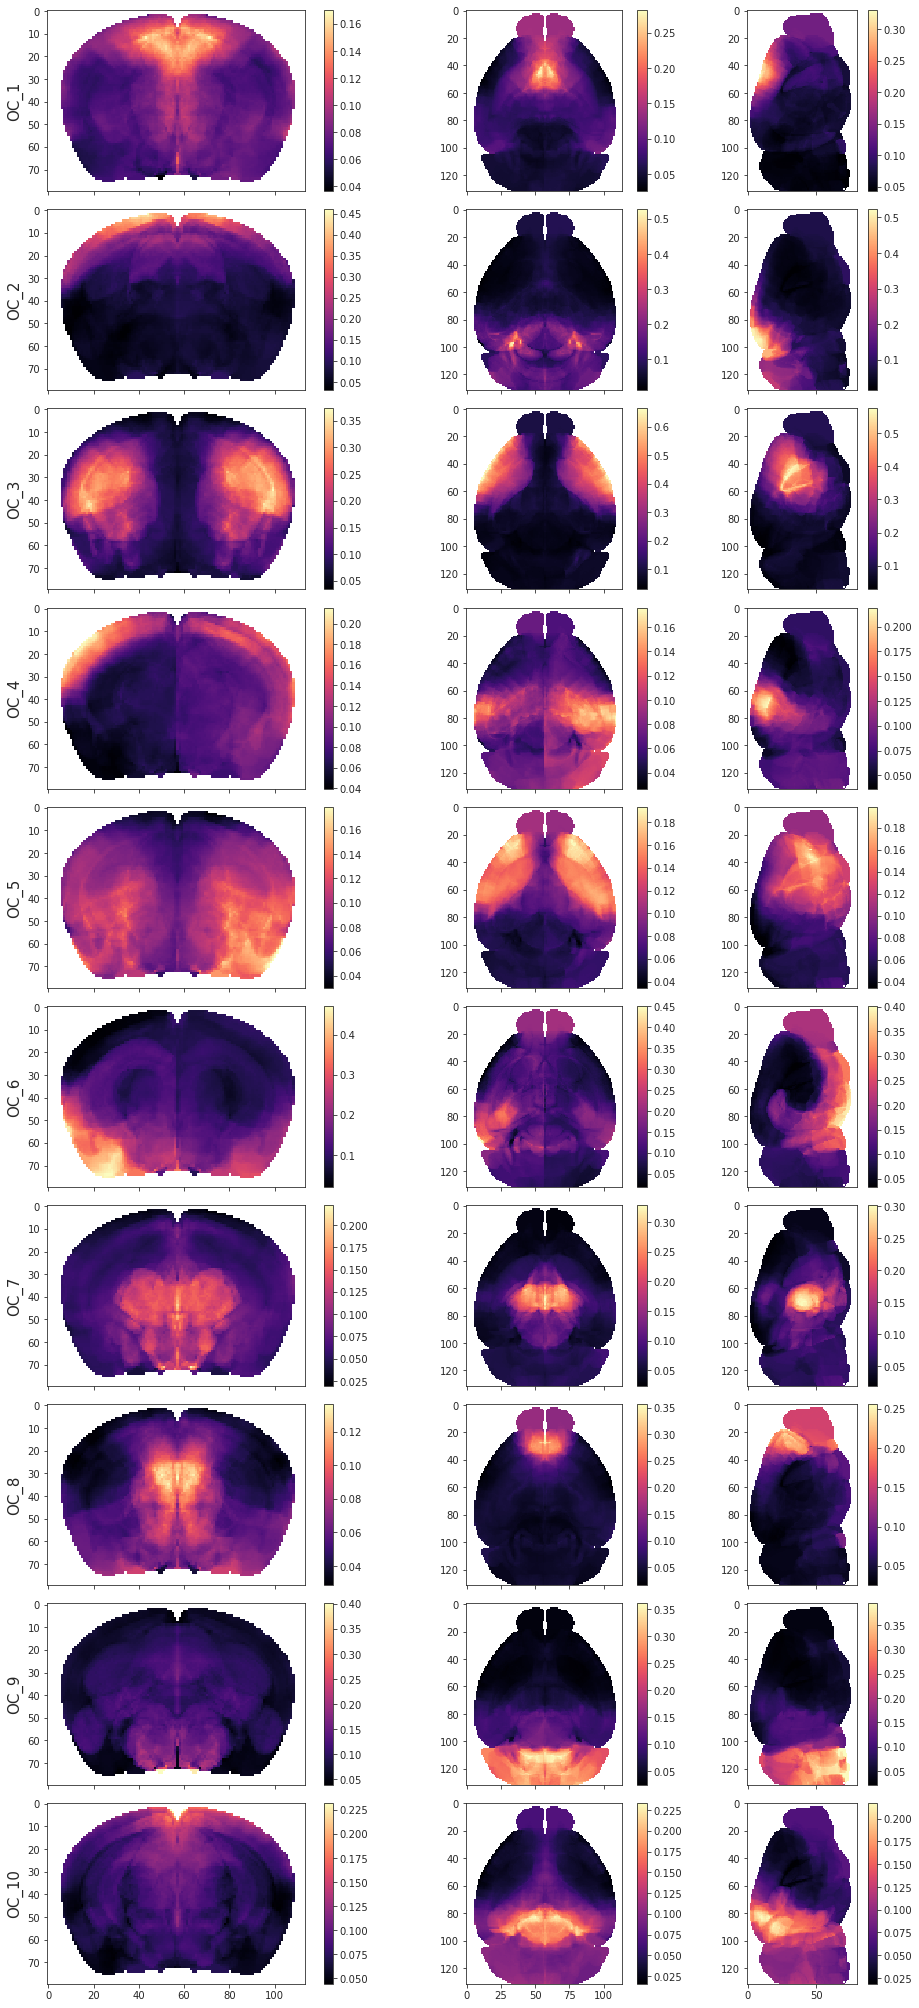

In [25]:
fig, axes = create_figure(bt.num_k, 3, (13, 2.8 * bt.num_k), 'col', 'col', width_ratios=[1.7, 1.4, 1])

for i in range(bt.num_k):
    for j, ax in enumerate(axes[i]):
        im = ax.imshow(bn.nanmean(pi_vol[i], j), cmap='magma')
        plt.colorbar(im, ax=ax)
        if j == 0:
            ax.set_ylabel(f"OC_{i + 1}", fontsize=15)
plt.show()

In [26]:
bt.pi_symmetry_score()

(
    {
        1: 0.988,
        2: 0.983,
        3: 0.985,
        4: 0.858,
        5: 0.96,
        6: 0.868,
        7: 0.993,
        8: 0.994,
        9: 0.988,
        10: 0.969,
        -1: 0.959
    },
    {
        1: 0.996,
        2: 0.983,
        3: 0.972,
        4: 0.95,
        5: 0.987,
        6: 0.965,
        7: 0.996,
        8: 0.994,
        9: 0.993,
        10: 0.985,
        -1: 0.982
    }
)

### Cut

In [27]:
bins = np.linspace(0.2, 1, 5)
bins

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [28]:
cut = cut_data(
    data=bt.run_pi.reshape(-1, bt.num_k, len(bt.n2l)),
    bins=bins,
    decimals=5,
    oc_only=True,
)[0].reshape((*bt.run_pi.shape[:4], bt.num_k, -1))
cut_pr = cut_data(
    data=bt.pi_prune.reshape(-1, bt.num_k, len(bt.n2l)),
    bins=bins,
    decimals=5,
    oc_only=True,
)[0].reshape((*bt.pi_prune.shape[:4], bt.num_k, -1))

cut_avg = avg(cut)
cut_pr_avg = avg(cut_pr)

cut_avg.shape, cut_pr_avg.shape

((10, 4), (10, 4))

In [29]:
cut_pr_avg[:, -1]

array([ 8.30630884, 14.92990489, 16.90306948,  7.19565152,  6.17155824,
       10.98574217,  9.48073524,  9.59949748, 12.64347825,  8.70892743])

In [30]:
cut_avg[:, -1]

array([ 7.98220528, 13.60075468, 15.28863192,  6.87214394,  5.8785656 ,
       10.62687223,  9.04301796,  9.24169295, 12.25862587,  8.18858838])

In [31]:
cut_pr_avg[:, -1] - cut_avg[:, -1]

array([0.32410355, 1.32915021, 1.61443756, 0.32350759, 0.29299264,
       0.35886993, 0.43771729, 0.35780453, 0.38485238, 0.52033905])

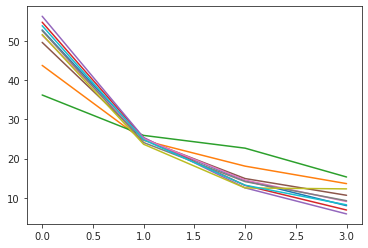

In [32]:
plt.plot(cut_avg.T);

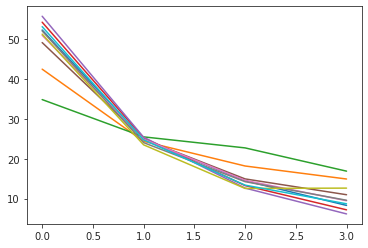

In [33]:
plt.plot(cut_pr_avg.T);

## Entropy & Cartography

In [40]:
# HIDE CODE


def plot_cartography(
    df: pd.DataFrame,
    palette: Dict[str, str],
    x_var: str = 'ent',
    y_var: str = 'deg',
    xlim: Tuple[float, float] = None,
    ylim: Tuple[float, float] = None,
    hue: str = 'oc_idx',
    grid: bool = True,
    display: bool = True,
    leg_size: float = 14,
    size: float = 7,
    scatter_kws: dict = None,
    density_kws: dict = None,
    median_kws: dict = None, ):
    
    scatter_kws = scatter_kws if scatter_kws else {
        's': 120,
        'alpha': 0.9,
        'edgecolor': 'dimgrey',
    }
    density_kws = density_kws if density_kws else {
        'lw': 2,
        'fill': True,
        'alpha': 0.5,
    }
    median_kws = median_kws if median_kws else {
        'lw': 1.5,
        'ls': '--',
        'zorder': 0,
        'alpha': 1.0,
        'c': sns.color_palette('deep')[7],
    }
    
    set_style('ticks')
    jg = sns.JointGrid(
        data=df,
        x=x_var,
        y=y_var,
        hue=hue,
        size=size,
        palette=palette,
        xlim=xlim,
        ylim=ylim,
        space=0.0,
    )
    # joint: scatter
    jg.plot_joint(
        sns.scatterplot,
        hue=hue,
        **scatter_kws,
    )
    # margnials: density
    jg.plot_marginals(
        sns.kdeplot,
        **density_kws,
    )
    # medians
    for name in [x_var, y_var]:
        x = df[name].median()
        lbl = f"median {name}: {x:.2f}"
        if name == x_var:
            jg.refline(x=x, label=lbl, **median_kws)
        else:
            jg.refline(y=x, label=lbl, **median_kws)
    # legend
    jg.ax_joint.legend(loc='upper left', prop={'size': leg_size})
    leg = jg.ax_joint.get_legend()
    if leg is not None:
        plt.setp(leg, bbox_to_anchor=(1.3, 1.0))
    
    if grid:
        jg.ax_joint.grid()
    
    if display:
        plt.show()
    else:
        plt.close()
    return jg

In [38]:
df = bt.mk_cartography_df(affil=[None] * len(bt.n2l))

In [58]:
scatter_kws = {
    's': 50,
    'alpha': 0.9,
    'edgecolor': 'dimgrey',
}

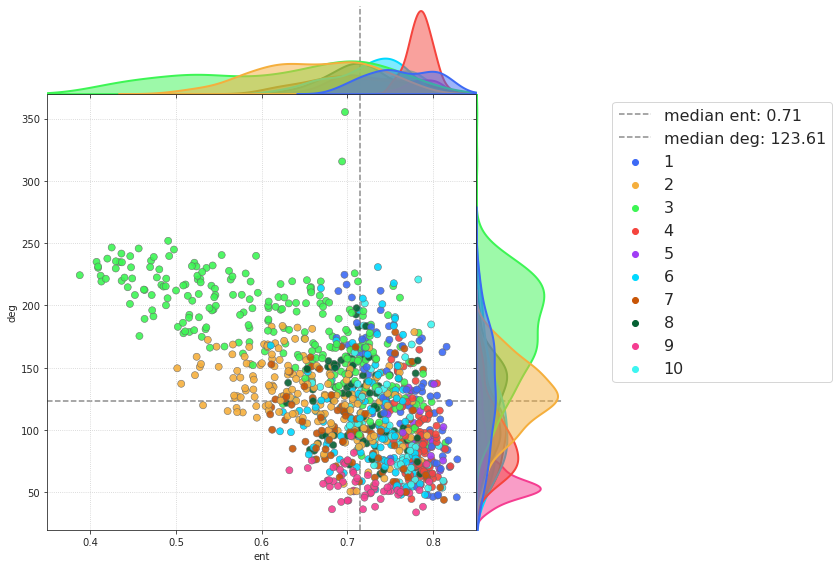

In [59]:
_ = plot_cartography(
    df=df,
    palette=bt.colors,
    x_var='ent',
    y_var='deg',
    xlim=(0.35, 0.85),
    ylim=(20, 370),
    hue='oc_idx',
    grid=True,
    display=True,
    leg_size=16,
    size=8,
    scatter_kws=scatter_kws,
)

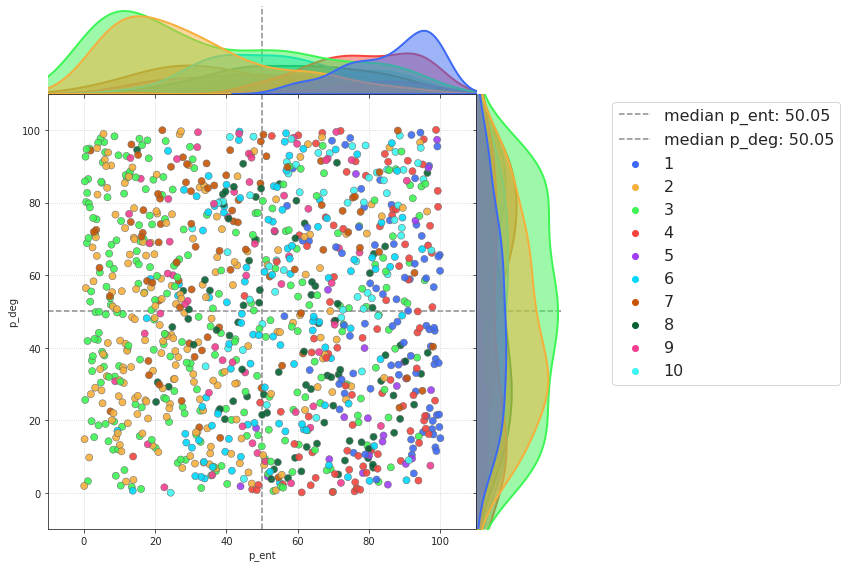

In [60]:
_ = plot_cartography(
    df=df,
    palette=bt.colors,
    x_var='p_ent',
    y_var='p_deg',
    xlim=(-10, 110),
    ylim=(-10, 110),
    hue='oc_idx',
    grid=True,
    display=True,
    leg_size=16,
    size=8,
    scatter_kws=scatter_kws,
)

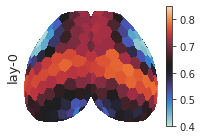

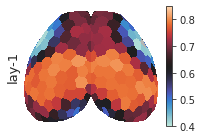

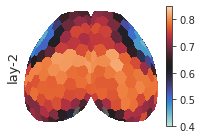

In [97]:
for i in range(3):
    _ = bt.show(
        data={f'lay-{i}': df['ent'].values},
        vmin=0.4,
        vmax=0.85,
        add_disjoint=False,
        figsize=(3, 2.2),
        contour=False,
        cmap='icefire',
        cbar=True,
        layer=i,
    )

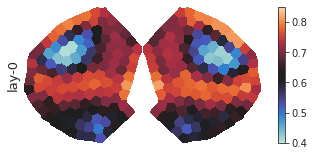

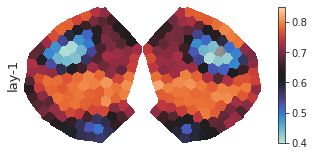

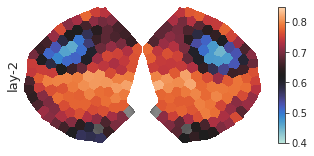

In [98]:
for i in range(3):
    _ = bt.show(
        data={f'lay-{i}': df['ent'].values},
        vmin=0.4,
        vmax=0.85,
        add_disjoint=False,
        figsize=(6, 2.5),
        contour=False,
        cmap='icefire',
        proj='flat',
        cbar=True,
        layer=i,
    )

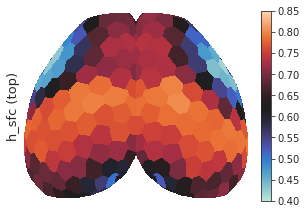

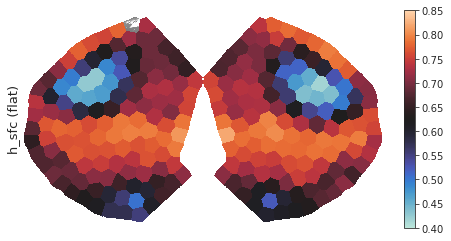

In [99]:
h_sfc = bt.get_surface_pi(df['ent'].values.reshape(1, -1)).squeeze()
_ = bt.show(
    data={'h_sfc (top)': h_sfc},
    vmin=0.4,
    vmax=0.85,
    add_disjoint=False,
    figsize=(5, 3.5),
    contour=False,
    cbar=True,
    cmap='icefire',
)
_ = bt.show(
    data={'h_sfc (flat)': h_sfc},
    vmin=0.4,
    vmax=0.85,
    add_disjoint=False,
    cbar=True,
    figsize=(8, 4),
    contour=False,
    proj='flat',
    cmap='icefire',
)